<a href="https://colab.research.google.com/github/minsuk-heo/tf2/blob/master/jupyter_notebooks/10.Word2Vec_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentence Classification using LSTM and Pretrained Word2Vec

We will train and test sentence classification using LSTM, and Pretrained Word2Vec.  
You can find visualization of our code below.

In [11]:
from IPython.display import Image
Image(url= "https://raw.githubusercontent.com/minsuk-heo/tf2/master/img/10_train.png", width=800, height=300)

The most benefits from Pretrained Word Embedding is<br>even unseen words during traning can be predicted well, since pretrained word embedding already trained with larger data set than your train data.

for example, below example also can be predicted well, even "this", "best", "show" were not in the train data.<br> Since "this" is similar to "it", "best" is similar to "good" and "show" is similar to "movie" in pretrained word embedding vector. 

In [13]:
from IPython.display import Image
Image(url= "https://raw.githubusercontent.com/minsuk-heo/tf2/master/img/10_test.png", width=800, height=300)

If you want to understand the detail of Word2Vec, here is well explained video.

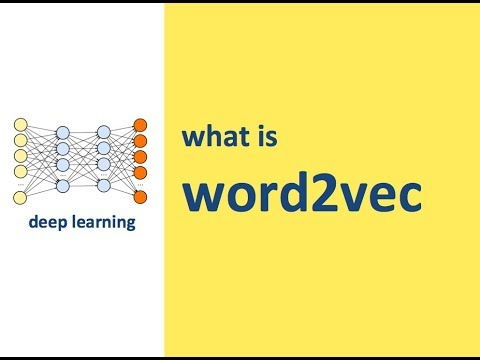

In [22]:
from IPython.display import YouTubeVideo
YouTubeVideo('64qSgA66P-8')

We will use LSTM, so we can generate sentence vector with sequence of word embedding.<br>LSTM is advanced RNN which is powerful on long sequence input.

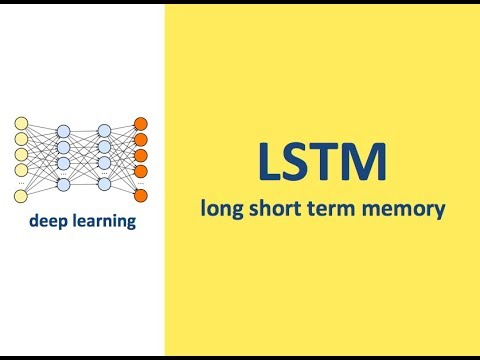

In [21]:
YouTubeVideo('m2cg32uEeZw')

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd

import tensorflow_hub as hub
import numpy as np

In [ ]:
# Load Pretrained Word2Vec
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

In [ ]:
def get_max_length(df):
    """
    get max token counts from train data, 
    so we use this number as fixed length input to RNN cell
    """
    max_length = 0
    for row in df['review']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

def get_word2vec_enc(reviews):
    """
    get word2vec value for each word in sentence.
    concatenate word in numpy array, so we can use it as RNN input
    """
    encoded_reviews = []
    for review in reviews:
        tokens = review.split(" ")
        word2vec_embedding = embed(tokens)
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews
        
def get_padded_encoded_reviews(encoded_reviews):
    """
    for short sentences, we prepend zero padding so all input to RNN has same length
    """
    padded_reviews_encoding = []
    for enc_review in encoded_reviews:
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, 250))
        for i in range(zero_padding_cnt):
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

def sentiment_encode(sentiment):
    """
    return one hot encoding for Y value
    """
    if sentiment == 'positive':
        return [1,0]
    else:
        return [0,1]
    
def preprocess(df):
    """
    encode text value to numeric value
    """
    # encode words into word2vec
    reviews = df['review'].tolist()
    
    encoded_reviews = get_word2vec_enc(reviews)
    padded_encoded_reviews = get_padded_encoded_reviews(encoded_reviews)
    # encoded sentiment
    sentiments = df['sentiment'].tolist()
    encoded_sentiment = [sentiment_encode(sentiment) for sentiment in sentiments]
    X = np.array(padded_encoded_reviews)
    Y = np.array(encoded_sentiment)
    return X, Y 

# Preprocess (encode text to number)

In [ ]:
movie_reviews_train = [
         {'review': 'this is the best movie', 'sentiment': 'positive'},
         {'review': 'i recommend you watch this movie', 'sentiment': 'positive'},
         {'review': 'it was waste of money and time', 'sentiment': 'negative'},
         {'review': 'the worst movie ever', 'sentiment': 'negative'}
    ]
df = pd.DataFrame(movie_reviews_train)

# max_length is used for max sequence of input
max_length = get_max_length(df)

train_X, train_Y = preprocess(df)

# Build Model

In [ ]:
# LSTM model
model = Sequential()
model.add(LSTM(32))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train

In [ ]:
print('Train...')
model.fit(train_X, train_Y,epochs=50)

In [ ]:
model.summary()

# Test
your model can predict correctly even for unseen words from training.  
This is the most benefit of using pretrained word embedding.  
Why? pretrained embedding will encode [better], [nice] to similar vector of [best]  
even if these words were not in train.  
therefore, the input vector to RNN is similar, so correct answers for even these unseen words.

In [ ]:
"""
movie_reviews_train = [
         {'review': 'this is the best movie', 'sentiment': 'positive'},
         {'review': 'i recommend you watch this movie', 'sentiment': 'positive'},
         {'review': 'it was waste of money and time', 'sentiment': 'negative'},
         {'review': 'the worst movie ever', 'sentiment': 'negative'}
    ]
"""
movie_reviews_test = [
         {'review': 'it is better movie', 'sentiment': 'positive'},
         {'review': 'i suggest you see this movie', 'sentiment': 'positive'},
         {'review': 'it was just throwing 20 dollars away', 'sentiment': 'negative'},
         {'review': 'worse than any show', 'sentiment': 'negative'},
         {'review': 'nice movie, so love it', 'sentiment': 'positive'},
         {'review': 'terrible', 'sentiment': 'negative'}
    ]
test_df = pd.DataFrame(movie_reviews_test)

test_X, test_Y = preprocess(test_df)

score, acc = model.evaluate(test_X, test_Y, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)